In [34]:
from pyspark import SparkContext, SparkConf
conf = SparkConf().setAppName("Spark Count")
sc = SparkContext(conf=conf)

In [35]:
spark = SparkSession.builder \
    .master("local") \
    .appName("Spark Count") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()


In [36]:
#libraries 
from pyspark.sql import Row
from pyspark.sql.types import *
from pyspark.sql.functions import udf
import re
from pyspark.mllib.clustering import KMeans, KMeansModel
import math
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.ml.feature import VectorAssembler
from pyspark.mllib.evaluation import RegressionMetrics

In [37]:
movie= sc.textFile("movies.dat") 

In [38]:
movie= movie.map(lambda x:x.split('::'))
movie.collect()

[['1', 'Toy Story (1995)', "Animation|Children's|Comedy"],
 ['2', 'Jumanji (1995)', "Adventure|Children's|Fantasy"],
 ['3', 'Grumpier Old Men (1995)', 'Comedy|Romance'],
 ['4', 'Waiting to Exhale (1995)', 'Comedy|Drama'],
 ['5', 'Father of the Bride Part II (1995)', 'Comedy'],
 ['6', 'Heat (1995)', 'Action|Crime|Thriller'],
 ['7', 'Sabrina (1995)', 'Comedy|Romance'],
 ['8', 'Tom and Huck (1995)', "Adventure|Children's"],
 ['9', 'Sudden Death (1995)', 'Action'],
 ['10', 'GoldenEye (1995)', 'Action|Adventure|Thriller'],
 ['11', 'American President, The (1995)', 'Comedy|Drama|Romance'],
 ['12', 'Dracula: Dead and Loving It (1995)', 'Comedy|Horror'],
 ['13', 'Balto (1995)', "Animation|Children's"],
 ['14', 'Nixon (1995)', 'Drama'],
 ['15', 'Cutthroat Island (1995)', 'Action|Adventure|Romance'],
 ['16', 'Casino (1995)', 'Drama|Thriller'],
 ['17', 'Sense and Sensibility (1995)', 'Drama|Romance'],
 ['18', 'Four Rooms (1995)', 'Thriller'],
 ['19', 'Ace Ventura: When Nature Calls (1995)', 'Come

In [39]:
# finding  unique genres 
generes= movie.flatMap(lambda x:x[2].split('|'))
generes=generes.collect()
m=list(set(generes))
m.sort()

In [40]:
movie = movie.map(lambda x: Row(movieid=x[0], name=x[1],generes=x[2]))
l=movie.toDF()
l.show()

+-------+--------------------+--------------------+
|movieid|                name|             generes|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Animation|Childre...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|        Comedy|Drama|
|      5|Father of the Bri...|              Comedy|
|      6|         Heat (1995)|Action|Crime|Thri...|
|      7|      Sabrina (1995)|      Comedy|Romance|
|      8| Tom and Huck (1995)|Adventure|Children's|
|      9| Sudden Death (1995)|              Action|
|     10|    GoldenEye (1995)|Action|Adventure|...|
|     11|American Presiden...|Comedy|Drama|Romance|
|     12|Dracula: Dead and...|       Comedy|Horror|
|     13|        Balto (1995)|Animation|Children's|
|     14|        Nixon (1995)|               Drama|
|     15|Cutthroat Island ...|Action|Adventure|...|
|     16|       Casino (1995)|      Drama|Thriller|
|     17|Sen

In [41]:

def Genere(value):
    a=[]
    for i in m:
        if   re.search(i,value): 
            a.append(1)
        else : 
            a.append(0)
    return a
        

In [42]:
udfAnimation = udf(Genere, ArrayType(IntegerType()))

n = l.withColumn("genecode", udfAnimation("generes"))


In [43]:
w=n.select([n.movieid]+[n.name] + [n.genecode[i] for i in range(0,18)])#exploading array column

In [44]:
a=[]
for i in range(18):
    a.append('genecode'+'['+str(i)+']') # storing genere code name 

In [45]:
for i in range(0,18):
    w = w.withColumnRenamed(a[i],m[i])#renaming with generes 
w.show()

+-------+--------------------+------+---------+---------+----------+------+-----+-----------+-----+-------+---------+------+-------+-------+-------+------+--------+---+-------+
|movieid|                name|Action|Adventure|Animation|Children's|Comedy|Crime|Documentary|Drama|Fantasy|Film-Noir|Horror|Musical|Mystery|Romance|Sci-Fi|Thriller|War|Western|
+-------+--------------------+------+---------+---------+----------+------+-----+-----------+-----+-------+---------+------+-------+-------+-------+------+--------+---+-------+
|      1|    Toy Story (1995)|     0|        0|        1|         1|     1|    0|          0|    0|      0|        0|     0|      0|      0|      0|     0|       0|  0|      0|
|      2|      Jumanji (1995)|     0|        1|        0|         1|     0|    0|          0|    0|      1|        0|     0|      0|      0|      0|     0|       0|  0|      0|
|      3|Grumpier Old Men ...|     0|        0|        0|         0|     1|    0|          0|    0|      0|        

In [46]:
p=w.select("Action","Adventure","Animation","Children's","Comedy","Crime","Documentary","Drama","Fantasy","Film-Noir","Horror","Musical","Mystery","Romance","Sci-Fi","Thriller","War","Western").rdd

In [47]:
p=p.map(lambda x:[x[i] for i in range(0,18)])

In [48]:
def error(point):
    center = clusters.centers[clusters.predict(point)]
    return math.sqrt(sum([x**2 for x in (point -center)]))

In [49]:
m=[]
for i in range(1,10):
    clusters = KMeans.train(p, i, initializationMode="random")
    cost = p.map(lambda p:error(p)).reduce(lambda x, y: x + y)
    m.append((i,cost))

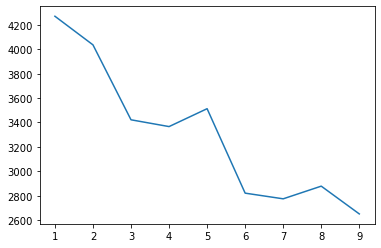

In [50]:
x=pd.DataFrame(m)  #plotting elbow method 
plt.plot(x[0],x[1]) 

In [51]:
clusters = KMeans.train(p, 6, initializationMode="random")

In [52]:
def w(value):
    return clusters.predict(value)

In [53]:
udfAnimation = udf(w, IntegerType())

n = n.withColumn("clust", udfAnimation("genecode")) # extracting predicted cluster column to dataframe 
n.show()

+-------+--------------------+--------------------+--------------------+-----+
|movieid|                name|             generes|            genecode|clust|
+-------+--------------------+--------------------+--------------------+-----+
|      1|    Toy Story (1995)|Animation|Childre...|[0, 0, 1, 1, 1, 0...|    4|
|      2|      Jumanji (1995)|Adventure|Childre...|[0, 1, 0, 1, 0, 0...|    2|
|      3|Grumpier Old Men ...|      Comedy|Romance|[0, 0, 0, 0, 1, 0...|    3|
|      4|Waiting to Exhale...|        Comedy|Drama|[0, 0, 0, 0, 1, 0...|    0|
|      5|Father of the Bri...|              Comedy|[0, 0, 0, 0, 1, 0...|    4|
|      6|         Heat (1995)|Action|Crime|Thri...|[1, 0, 0, 0, 0, 1...|    2|
|      7|      Sabrina (1995)|      Comedy|Romance|[0, 0, 0, 0, 1, 0...|    3|
|      8| Tom and Huck (1995)|Adventure|Children's|[0, 1, 0, 1, 0, 0...|    2|
|      9| Sudden Death (1995)|              Action|[1, 0, 0, 0, 0, 0...|    2|
|     10|    GoldenEye (1995)|Action|Adventure|...|[

In [54]:
rating= sc.textFile("ratings.dat")
rating= rating.map(lambda x:x.split('::'))
rating = rating.map(lambda x: Row(userid=x[0], movieid=x[1],rating=x[2],timestamp=x[3]))
rating=rating.toDF()
rating.show()

+------+-------+------+---------+
|userid|movieid|rating|timestamp|
+------+-------+------+---------+
|     1|   1193|     5|978300760|
|     1|    661|     3|978302109|
|     1|    914|     3|978301968|
|     1|   3408|     4|978300275|
|     1|   2355|     5|978824291|
|     1|   1197|     3|978302268|
|     1|   1287|     5|978302039|
|     1|   2804|     5|978300719|
|     1|    594|     4|978302268|
|     1|    919|     4|978301368|
|     1|    595|     5|978824268|
|     1|    938|     4|978301752|
|     1|   2398|     4|978302281|
|     1|   2918|     4|978302124|
|     1|   1035|     5|978301753|
|     1|   2791|     4|978302188|
|     1|   2687|     3|978824268|
|     1|   2018|     4|978301777|
|     1|   3105|     5|978301713|
|     1|   2797|     4|978302039|
+------+-------+------+---------+
only showing top 20 rows



In [55]:
movie=n.join(rating,n.movieid==rating.movieid)
movieclustrate=movie.select("userid","clust","rating")
movieclustrate=movieclustrate.selectExpr("cast(rating as int) rating",
                                            "cast(userid as string) userid",
                                            "cast(clust as string) clust")
movieclustrate=movieclustrate.groupby("userid","clust").avg("rating")
movieclustrate.show()

+------+-----+------------------+
|userid|clust|       avg(rating)|
+------+-----+------------------+
|    26|    0|         3.3984375|
|  1639|    0| 3.896039603960396|
|  2653|    0|3.5384615384615383|
|  3624|    0| 4.232323232323233|
|  4072|    0|3.8392857142857144|
|  5614|    0| 3.926517571884984|
|  5755|    0| 3.760330578512397|
|  4593|    0|3.4598930481283423|
|  1059|    4| 2.701388888888889|
|  3471|    4| 3.029268292682927|
|  3957|    4| 3.324324324324324|
|  5519|    4|3.3058823529411763|
|  2731|    4|4.0675675675675675|
|  1119|    2|3.5352941176470587|
|  1805|    2| 3.847457627118644|
|  1181|    2|2.7744510978043913|
|  3642|    2|              1.75|
|  4022|    2|            2.9375|
|  5306|    2| 3.331578947368421|
|  5394|    2|3.0616740088105727|
+------+-----+------------------+
only showing top 20 rows



In [56]:
movieavg=movie.join(movieclustrate,(movieclustrate.userid==movie.userid) &(movieclustrate.clust==movie.clust))

In [57]:
valuesAndPreds=movieavg.select("rating","avg(rating)").rdd
metrics = RegressionMetrics(valuesAndPreds)

In [58]:
print("RMSE = %s" % metrics.rootMeanSquaredError)

Py4JJavaError: An error occurred while calling o1142.rootMeanSquaredError.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 156.0 failed 1 times, most recent failure: Lost task 0.0 in stage 156.0 (TID 946, 10.0.2.15, executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/home/vipul/Downloads/spark-3.0.1-bin-hadoop3.2/python/lib/pyspark.zip/pyspark/worker.py", line 605, in main
    process()
  File "/home/vipul/Downloads/spark-3.0.1-bin-hadoop3.2/python/lib/pyspark.zip/pyspark/worker.py", line 597, in process
    serializer.dump_stream(out_iter, outfile)
  File "/home/vipul/Downloads/spark-3.0.1-bin-hadoop3.2/python/lib/pyspark.zip/pyspark/serializers.py", line 271, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/home/vipul/Downloads/spark-3.0.1-bin-hadoop3.2/python/lib/pyspark.zip/pyspark/util.py", line 107, in wrapper
    return f(*args, **kwargs)
  File "/home/vipul/Downloads/spark-3.0.1-bin-hadoop3.2/python/pyspark/sql/session.py", line 612, in prepare
    verify_func(obj)
  File "/home/vipul/Downloads/spark-3.0.1-bin-hadoop3.2/python/pyspark/sql/types.py", line 1408, in verify
    verify_value(obj)
  File "/home/vipul/Downloads/spark-3.0.1-bin-hadoop3.2/python/pyspark/sql/types.py", line 1389, in verify_struct
    verifier(v)
  File "/home/vipul/Downloads/spark-3.0.1-bin-hadoop3.2/python/pyspark/sql/types.py", line 1408, in verify
    verify_value(obj)
  File "/home/vipul/Downloads/spark-3.0.1-bin-hadoop3.2/python/pyspark/sql/types.py", line 1402, in verify_default
    verify_acceptable_types(obj)
  File "/home/vipul/Downloads/spark-3.0.1-bin-hadoop3.2/python/pyspark/sql/types.py", line 1286, in verify_acceptable_types
    raise TypeError(new_msg("%s can not accept object %r in type %s"
TypeError: field prediction: DoubleType can not accept object '1' in type <class 'str'>

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:503)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:638)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:621)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:456)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:489)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:729)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at scala.collection.Iterator.foreach(Iterator.scala:941)
	at scala.collection.Iterator.foreach$(Iterator.scala:941)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1429)
	at scala.collection.TraversableOnce.foldLeft(TraversableOnce.scala:162)
	at scala.collection.TraversableOnce.foldLeft$(TraversableOnce.scala:160)
	at scala.collection.AbstractIterator.foldLeft(Iterator.scala:1429)
	at scala.collection.TraversableOnce.aggregate(TraversableOnce.scala:219)
	at scala.collection.TraversableOnce.aggregate$(TraversableOnce.scala:219)
	at scala.collection.AbstractIterator.aggregate(Iterator.scala:1429)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$3(RDD.scala:1204)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$5(RDD.scala:1205)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:837)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:837)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:349)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:313)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:349)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:313)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:127)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:446)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1377)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:449)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:834)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2059)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2008)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2007)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2007)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:973)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:973)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:973)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2239)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2188)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2177)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:775)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2099)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2194)
	at org.apache.spark.rdd.RDD.$anonfun$fold$1(RDD.scala:1157)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:388)
	at org.apache.spark.rdd.RDD.fold(RDD.scala:1151)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$1(RDD.scala:1220)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:388)
	at org.apache.spark.rdd.RDD.treeAggregate(RDD.scala:1196)
	at org.apache.spark.mllib.stat.Statistics$.colStats(Statistics.scala:58)
	at org.apache.spark.mllib.evaluation.RegressionMetrics.summary$lzycompute(RegressionMetrics.scala:70)
	at org.apache.spark.mllib.evaluation.RegressionMetrics.summary(RegressionMetrics.scala:62)
	at org.apache.spark.mllib.evaluation.RegressionMetrics.SSerr$lzycompute(RegressionMetrics.scala:74)
	at org.apache.spark.mllib.evaluation.RegressionMetrics.SSerr(RegressionMetrics.scala:74)
	at org.apache.spark.mllib.evaluation.RegressionMetrics.meanSquaredError(RegressionMetrics.scala:106)
	at org.apache.spark.mllib.evaluation.RegressionMetrics.rootMeanSquaredError(RegressionMetrics.scala:115)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.base/java.lang.Thread.run(Thread.java:834)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/home/vipul/Downloads/spark-3.0.1-bin-hadoop3.2/python/lib/pyspark.zip/pyspark/worker.py", line 605, in main
    process()
  File "/home/vipul/Downloads/spark-3.0.1-bin-hadoop3.2/python/lib/pyspark.zip/pyspark/worker.py", line 597, in process
    serializer.dump_stream(out_iter, outfile)
  File "/home/vipul/Downloads/spark-3.0.1-bin-hadoop3.2/python/lib/pyspark.zip/pyspark/serializers.py", line 271, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/home/vipul/Downloads/spark-3.0.1-bin-hadoop3.2/python/lib/pyspark.zip/pyspark/util.py", line 107, in wrapper
    return f(*args, **kwargs)
  File "/home/vipul/Downloads/spark-3.0.1-bin-hadoop3.2/python/pyspark/sql/session.py", line 612, in prepare
    verify_func(obj)
  File "/home/vipul/Downloads/spark-3.0.1-bin-hadoop3.2/python/pyspark/sql/types.py", line 1408, in verify
    verify_value(obj)
  File "/home/vipul/Downloads/spark-3.0.1-bin-hadoop3.2/python/pyspark/sql/types.py", line 1389, in verify_struct
    verifier(v)
  File "/home/vipul/Downloads/spark-3.0.1-bin-hadoop3.2/python/pyspark/sql/types.py", line 1408, in verify
    verify_value(obj)
  File "/home/vipul/Downloads/spark-3.0.1-bin-hadoop3.2/python/pyspark/sql/types.py", line 1402, in verify_default
    verify_acceptable_types(obj)
  File "/home/vipul/Downloads/spark-3.0.1-bin-hadoop3.2/python/pyspark/sql/types.py", line 1286, in verify_acceptable_types
    raise TypeError(new_msg("%s can not accept object %r in type %s"
TypeError: field prediction: DoubleType can not accept object '1' in type <class 'str'>

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:503)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:638)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:621)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:456)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:489)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:729)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at scala.collection.Iterator.foreach(Iterator.scala:941)
	at scala.collection.Iterator.foreach$(Iterator.scala:941)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1429)
	at scala.collection.TraversableOnce.foldLeft(TraversableOnce.scala:162)
	at scala.collection.TraversableOnce.foldLeft$(TraversableOnce.scala:160)
	at scala.collection.AbstractIterator.foldLeft(Iterator.scala:1429)
	at scala.collection.TraversableOnce.aggregate(TraversableOnce.scala:219)
	at scala.collection.TraversableOnce.aggregate$(TraversableOnce.scala:219)
	at scala.collection.AbstractIterator.aggregate(Iterator.scala:1429)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$3(RDD.scala:1204)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$5(RDD.scala:1205)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:837)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:837)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:349)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:313)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:349)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:313)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:127)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:446)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1377)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:449)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	... 1 more


RMSE = 0.9897459721740606


0.9897459721740606

[('5', 3.5),
 ('1', 3.5),
 ('3', 3.5),
 ('5', 3.5),
 ('3', 3.5),
 ('4', 3.5),
 ('5', 4.0),
 ('4', 4.0),
 ('4', 4.0),
 ('4', 4.0),
 ('4', 4.0),
 ('4', 4.0),
 ('5', 4.0),
 ('5', 4.0),
 ('3', 4.0),
 ('3', 4.0),
 ('4', 4.0),
 ('3', 4.0),
 ('4', 4.0),
 ('4', 4.0),
 ('4', 4.0),
 ('5', 4.0),
 ('5', 4.0),
 ('5', 4.0),
 ('4', 4.0),
 ('4', 4.0),
 ('5', 4.0),
 ('5', 4.0),
 ('4', 4.0),
 ('4', 4.0),
 ('5', 4.0),
 ('4', 4.0),
 ('4', 4.0),
 ('3', 4.0),
 ('5', 4.0),
 ('4', 4.0),
 ('4', 4.0),
 ('3', 4.0),
 ('4', 4.0),
 ('3', 4.0),
 ('4', 4.0),
 ('3', 4.0),
 ('4', 4.0),
 ('3', 4.0),
 ('4', 4.0),
 ('4', 4.0),
 ('4', 4.0),
 ('3', 4.0),
 ('4', 4.0),
 ('4', 4.0),
 ('4', 4.0),
 ('4', 4.0),
 ('4', 4.0),
 ('4', 4.0),
 ('4', 4.0),
 ('4', 4.0),
 ('3', 4.0),
 ('4', 4.0),
 ('4', 4.0),
 ('5', 4.0),
 ('3', 4.0),
 ('4', 4.0),
 ('5', 4.111111111111111),
 ('5', 4.111111111111111),
 ('5', 4.111111111111111),
 ('5', 4.111111111111111),
 ('5', 4.111111111111111),
 ('3', 4.111111111111111),
 ('5', 4.111111111111111),
 ('4'

[(1, 4270.799399171748),
 (2, 3925.089188109675),
 (3, 4037.3742964730523),
 (4, 3287.6645672545164),
 (5, 3269.81675695369),
 (6, 2998.194021813938),
 (7, 3087.9161130268176),
 (8, 2935.719221866633),
 (9, 2485.8313444367823)]

[('0', ('1', '1193', '5')),
 ('9', ('1', '661', '3')),
 ('8', ('1', '914', '3')),
 ('5', ('1', '3408', '4')),
 ('1', ('1', '2355', '5')),
 ('8', ('1', '1197', '3')),
 ('9', ('1', '1287', '5')),
 ('9', ('1', '2804', '5')),
 ('8', ('1', '594', '4')),
 ('8', ('1', '919', '4')),
 ('8', ('1', '595', '5')),
 ('2', ('1', '938', '4')),
 ('1', ('1', '2398', '4')),
 ('4', ('1', '2918', '4')),
 ('3', ('1', '1035', '5')),
 ('8', ('1', '2791', '4')),
 ('8', ('1', '2687', '3')),
 ('7', ('1', '2018', '4')),
 ('3', ('1', '3105', '5')),
 ('9', ('1', '2797', '4')),
 ('5', ('1', '2321', '3')),
 ('0', ('1', '720', '3')),
 ('5', ('1', '1270', '5')),
 ('5', ('1', '527', '5')),
 ('3', ('1', '2340', '3')),
 ('1', ('1', '48', '5')),
 ('3', ('1', '1097', '4')),
 ('5', ('1', '1721', '4')),
 ('9', ('1', '1545', '4')),
 ('8', ('1', '745', '3')),
 ('1', ('1', '2294', '4')),
 ('9', ('1', '3186', '4')),
 ('0', ('1', '1566', '4')),
 ('8', ('1', '588', '4')),
 ('0', ('1', '1907', '4')),
 ('1', ('1', '783', '4')),
 ('2'

3

+-------+--------------------+--------------------+--------------------+-----+
|movieid|                name|             generes|            genecode|clust|
+-------+--------------------+--------------------+--------------------+-----+
|      1|    Toy Story (1995)|Animation|Childre...|[0, 0, 1, 1, 1, 0...|    3|
|      2|      Jumanji (1995)|Adventure|Childre...|[0, 1, 0, 1, 0, 0...|    1|
|      3|Grumpier Old Men ...|      Comedy|Romance|[0, 0, 0, 0, 1, 0...|    3|
|      4|Waiting to Exhale...|        Comedy|Drama|[0, 0, 0, 0, 1, 0...|    3|
|      5|Father of the Bri...|              Comedy|[0, 0, 0, 0, 1, 0...|    3|
|      6|         Heat (1995)|Action|Crime|Thri...|[1, 0, 0, 0, 0, 1...|    0|
|      7|      Sabrina (1995)|      Comedy|Romance|[0, 0, 0, 0, 1, 0...|    3|
|      8| Tom and Huck (1995)|Adventure|Children's|[0, 1, 0, 1, 0, 0...|    1|
|      9| Sudden Death (1995)|              Action|[1, 0, 0, 0, 0, 0...|    1|
|     10|    GoldenEye (1995)|Action|Adventure|...|[

In [32]:
sc.stop()

In [33]:
spark.stop()